In [18]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [19]:
RA50_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/cnn_acc85.0_auc0.9.h5"
RA50_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/tf_dataset_test.tf"

R80_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Right80/2022-11-01 23:21:54.774594/cnn_acc85.0_loss0.3.h5"
R80_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Right80/2022-11-01 23:21:54.774594/tf_dataset_test.tf"

R200_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Right200/2022-11-07 21:13:52.831721 Final 3/cnn_acc94.0_auc1.0.h5"
R200_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Right200/2022-11-07 21:13:52.831721 Final 3/tf_dataset_test.tf"

L200_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Left200/2022-11-07 16:43:59.702466 Final 3/cnn_acc84.0_auc0.9.h5"
L200_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Left200/2022-11-07 16:43:59.702466 Final 3/tf_dataset_test.tf"

F200_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Front200/2022-11-07 12:01:14.955083 Final 1/cnn_acc96.0_loss0.1.h5"
F200_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/Front200/2022-11-07 12:01:14.955083 Final 1/tf_dataset_test.tf"

path_model=RA50_Model
path_tf_dataset_test=RA50_Data



In [20]:
# Load model
#model = tf.keras.models.load_model("../training/model/trained_model.h5")
model = tf.keras.models.load_model(path_model)
# Read data
ds_test = tf.data.experimental.load(path_tf_dataset_test)
#load example picture

In [21]:
# Evaluate model
model.compile(loss='categorical_crossentropy', metrics='categorical_accuracy')
results = model.evaluate(ds_test, verbose=True)
print(f"Test loss {results[0]}, Test acc {results[1]}")

3/3 [==============================] - 1s 75ms/step - loss: 0.4755 - categorical_accuracy: 0.8548
Test loss 0.47549355030059814, Test acc 0.8547717928886414


In [1]:
# Model predict
y_test = [label for image,label in list(ds_test.unbatch().as_numpy_iterator())]
y_test_idx = tf.argmax(y_test, axis=1)
predictions = model.predict(ds_test)
predictions_idx = tf.argmax(predictions, axis=1)

NameError: name 'ds_test' is not defined

In [23]:
# Confusion matrix
conf_mat = tf.math.confusion_matrix(y_test_idx, predictions_idx)
print(conf_mat)

tf.Tensor(
[[259  36   0   0]
 [ 34 235  20   0]
 [  1  45 242  20]
 [  0   0  19 294]], shape=(4, 4), dtype=int32)


1/1 [==============================] - 0s 22ms/step


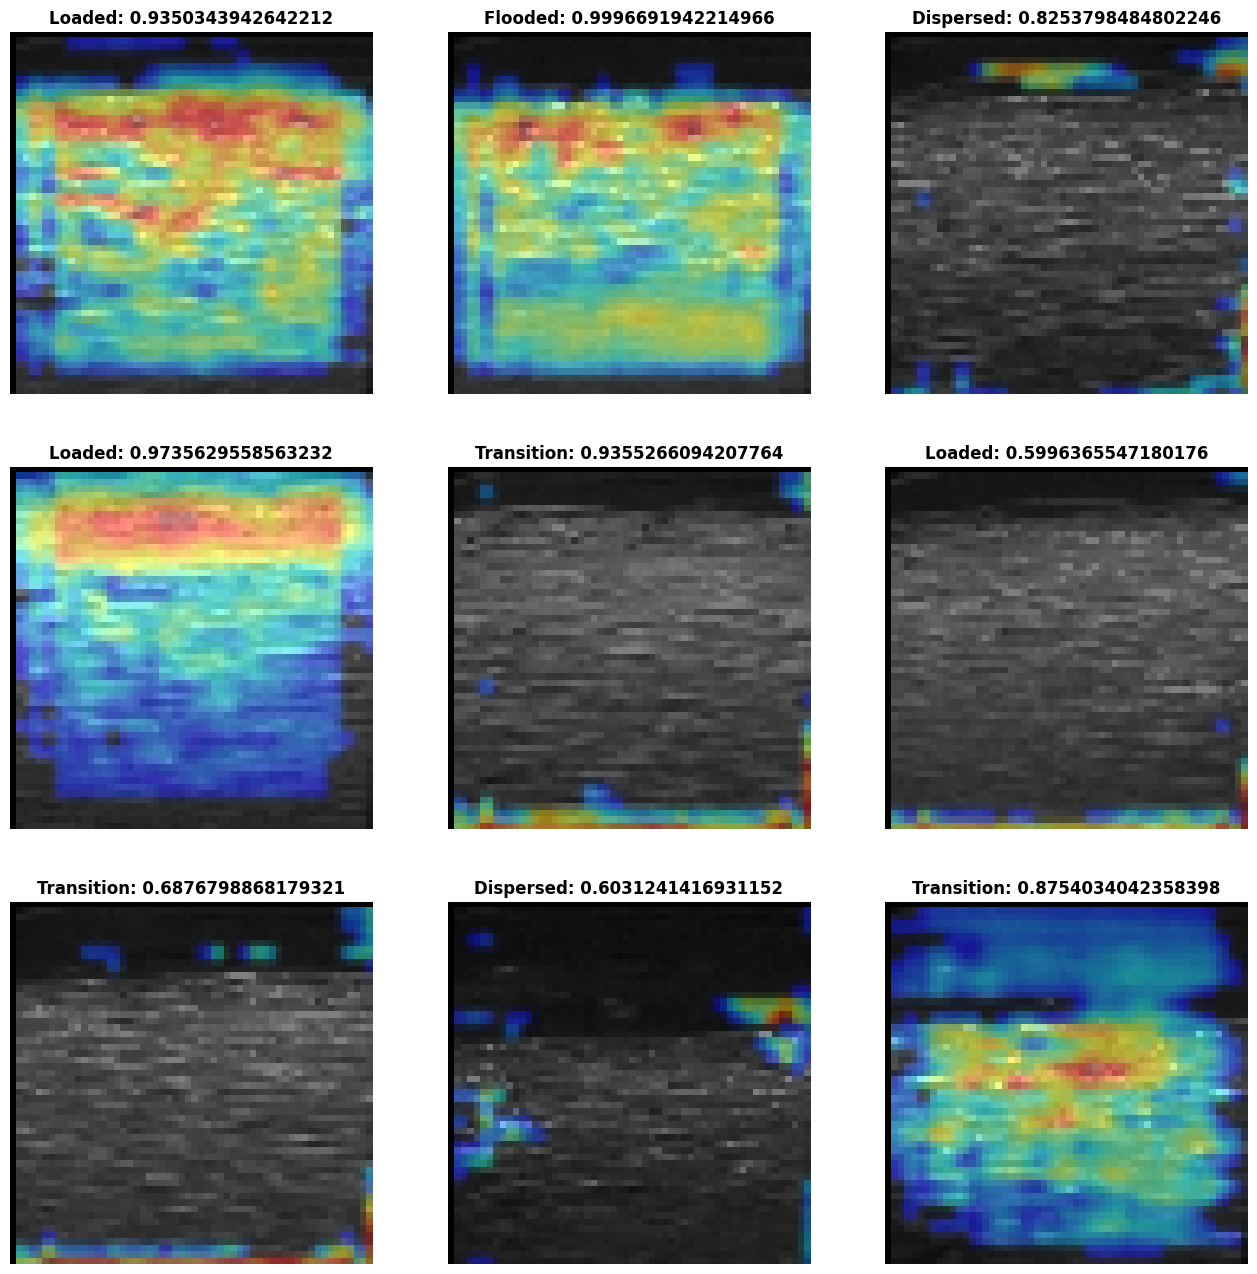

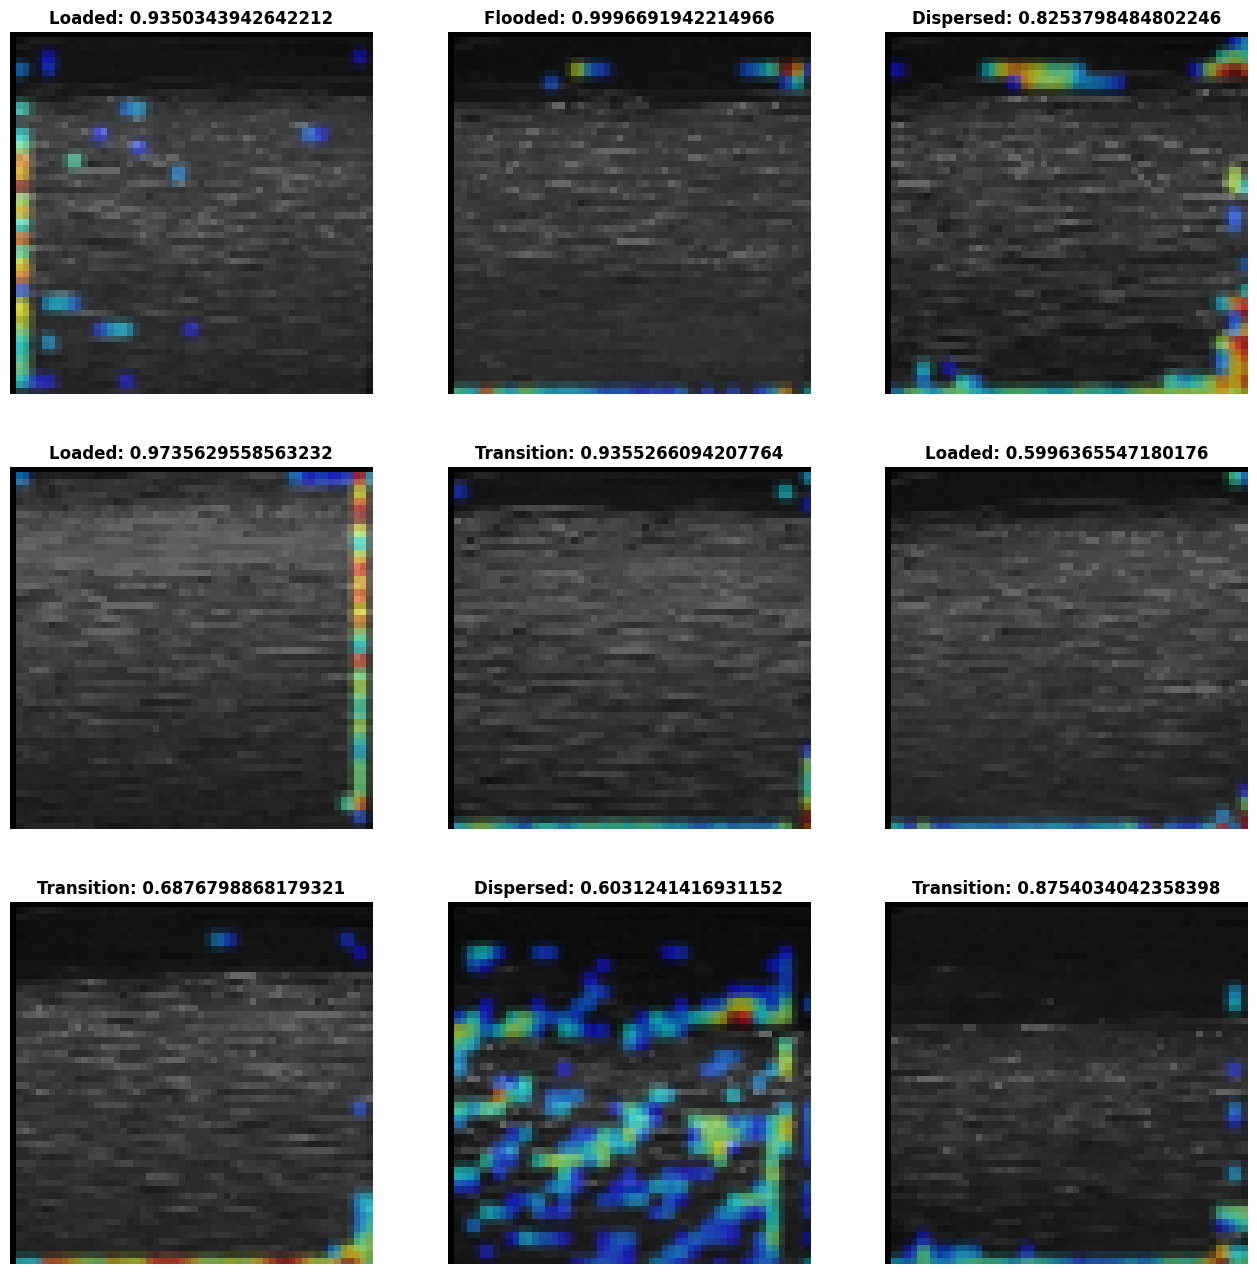

In [53]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
axs = axs.flatten()
import gradcamplusplus
import imutils #rotate image
import grad_cam
data_points= []
images_gradcammplusplus = []
images_gradcamm = []
preds_list = []
labels= []
for data_point, ax in zip(ds_test.unbatch().skip(10).take(9) ,axs):
    image, label = data_point
    image = image.numpy()
    label = label.numpy()
    labels.append(label)
    img_array = np.expand_dims(image, axis=0)
    # Print what the top predicted class is
    preds = model.predict(img_array)
    preds_list.append(preds)
    #Generate class activation heatmap
    heatmap_pp = gradcamplusplus.get_heatmap(image, model, 'conv2d_1')
    # heatmap = get_gradcam_heatmap(image, model, 'conv2d_1')
    #superimposed_image = combine_image_and_heatmap(image, heatmap, alpha=0.5)
    superimposed_image_pp=  gradcamplusplus.combine_image_and_heatmap(image, heatmap_pp, alpha=0.6,heatMapCorlorspace="jet")
    images_gradcammplusplus.append(superimposed_image_pp)

    heatmap = grad_cam.get_heatmap(image, model, 'conv2d_1')
    superimposed_image = grad_cam.combine_image_and_heatmap(image, heatmap, alpha=0.5)
    images_gradcamm.append(superimposed_image)

# GRAD CAM
for superimposed_image, ax ,preds,label in zip(images_gradcamm ,axs,preds_list,labels):
    # Display heatmap
    ax.imshow(imutils.rotate(superimposed_image,180))
    font_axis_publish = {
          'color':  'black',
          'weight': 'bold',
          'size': 12,
    }
    ax.axis('off')
    probs = preds.tolist()[0]
    inferedAccuracyFlooded      =probs[3]
    inferedAccuracyLoaded       =probs[2]
    inferedAccuracyTransistion    =probs[1]
    inferedAccuracyDispersed    =probs[0]
    classaccuracy = max(inferedAccuracyFlooded,inferedAccuracyDispersed,inferedAccuracyLoaded,inferedAccuracyTransistion)
    label_title = None
    if classaccuracy == inferedAccuracyFlooded:
      label_title=f'Flooded: {round(probs[3],2)}'
    elif classaccuracy == inferedAccuracyLoaded:
      label_title=f'Loaded: {round(probs[2],2)}'
    elif classaccuracy == inferedAccuracyTransistion:
      label_title=f'Transition: {round(probs[1],2)}'
    elif classaccuracy == inferedAccuracyDispersed:
      label_title=f'Dispersed: {round(probs[0],2)}'
    if 0 == label:
      label_title+= " Correct=Dispersed"
    elif 1 == label:
      label_title+= " Correct=Transition"
    elif 2 == label:
      label_title+= " Correct=Loaded"
    elif 3 == label:
      label_title+= " Correct=Flooded"
    ax.set_title(label_title, fontdict=font_axis_publish)
plt.savefig(f"{path_model.split('cnn')[0]}GC.png")
# GRAD CAM PLUS PLUS
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
axs = axs.flatten()
for superimposed_image, ax ,preds,label in zip(images_gradcammplusplus ,axs,preds_list,labels):
    # Display heatmap
    ax.imshow(imutils.rotate(superimposed_image,180))
    font_axis_publish = {
          'color':  'black',
          'weight': 'bold',
          'size': 12,
    }
    ax.axis('off')
    probs = preds.tolist()[0]
    inferedAccuracyFlooded      =probs[3]
    inferedAccuracyLoaded       =probs[2]
    inferedAccuracyTransistion    =probs[1]
    inferedAccuracyDispersed    =probs[0]
    classaccuracy = max(inferedAccuracyFlooded,inferedAccuracyDispersed,inferedAccuracyLoaded,inferedAccuracyTransistion)
    label_title = None
    if classaccuracy == inferedAccuracyFlooded:
      label_title=f'Flooded: {round(probs[3],2)}'
    elif classaccuracy == inferedAccuracyLoaded:
      label_title=f'Loaded: {round(probs[2],2)}'
    elif classaccuracy == inferedAccuracyTransistion:
      label_title=f'Transition: {round(probs[1],2)}'
    elif classaccuracy == inferedAccuracyDispersed:
      label_title=f'Dispersed: {round(probs[0],2)}'
    if 0 == label:
      label_title+= " Correct=Dispersed"
    elif 1 == label:
      label_title+= " Correct=Transition"
    elif 2 == label:
      label_title+= " Correct=Loaded"
    elif 3 == label:
      label_title+= " Correct=Flooded"
    ax.set_title(label_title, fontdict=font_axis_publish)
plt.savefig(f"{path_model.split('cnn')[0]}GCPP.png")



In [25]:
x_test = []
y_test = []
imgs= []
for image, label in list(ds_test.unbatch().as_numpy_iterator()):
    tf_image=tf.convert_to_tensor(image)
    tf_image_batched=tf.expand_dims(tf_image, axis=0)
    imgs.append(image)
    x_test.append(tf_image_batched) #images
    y_test.append(label) #labels
predictions = [model.predict_on_batch(x) for x in x_test]


In [26]:
from matplotlib import cm
import cv2

sum_disp    = np.zeros((28,28))
sum_trans   = np.zeros((28,28))
sum_load    = np.zeros((28,28))
sum_flood   = np.zeros((28,28))

count_disp  =0
count_trans =0
count_load  =0
count_flood =0

for image,label,preds in zip(imgs,y_test,predictions):
    #preds = model.predict(img_array,verbose=0)
    probs = preds.tolist()[0]
    pred=np.around(preds,3)
    prediction= pred[0]
    inferedAccuracyFlooded=prediction[3]
    inferedAccuracyLoaded=prediction[2]
    inferedAccuracyDispersed=prediction[1]
    inferedAccuracyTransistion=prediction[0]
    classaccuracy = max(inferedAccuracyFlooded,inferedAccuracyDispersed,inferedAccuracyLoaded,inferedAccuracyTransistion)
    heatmap = gradcamplusplus.get_heatmap(image, model, 'conv2d_1')
    if classaccuracy == inferedAccuracyFlooded:
        sum_flood+=heatmap
        count_flood+=1
    elif classaccuracy == inferedAccuracyLoaded:
        sum_load+=heatmap
        count_load+=1
    elif classaccuracy == inferedAccuracyTransistion:
        sum_trans+=heatmap
        count_trans+=1
    elif classaccuracy == inferedAccuracyDispersed:
        sum_disp+=heatmap
        count_disp+=1

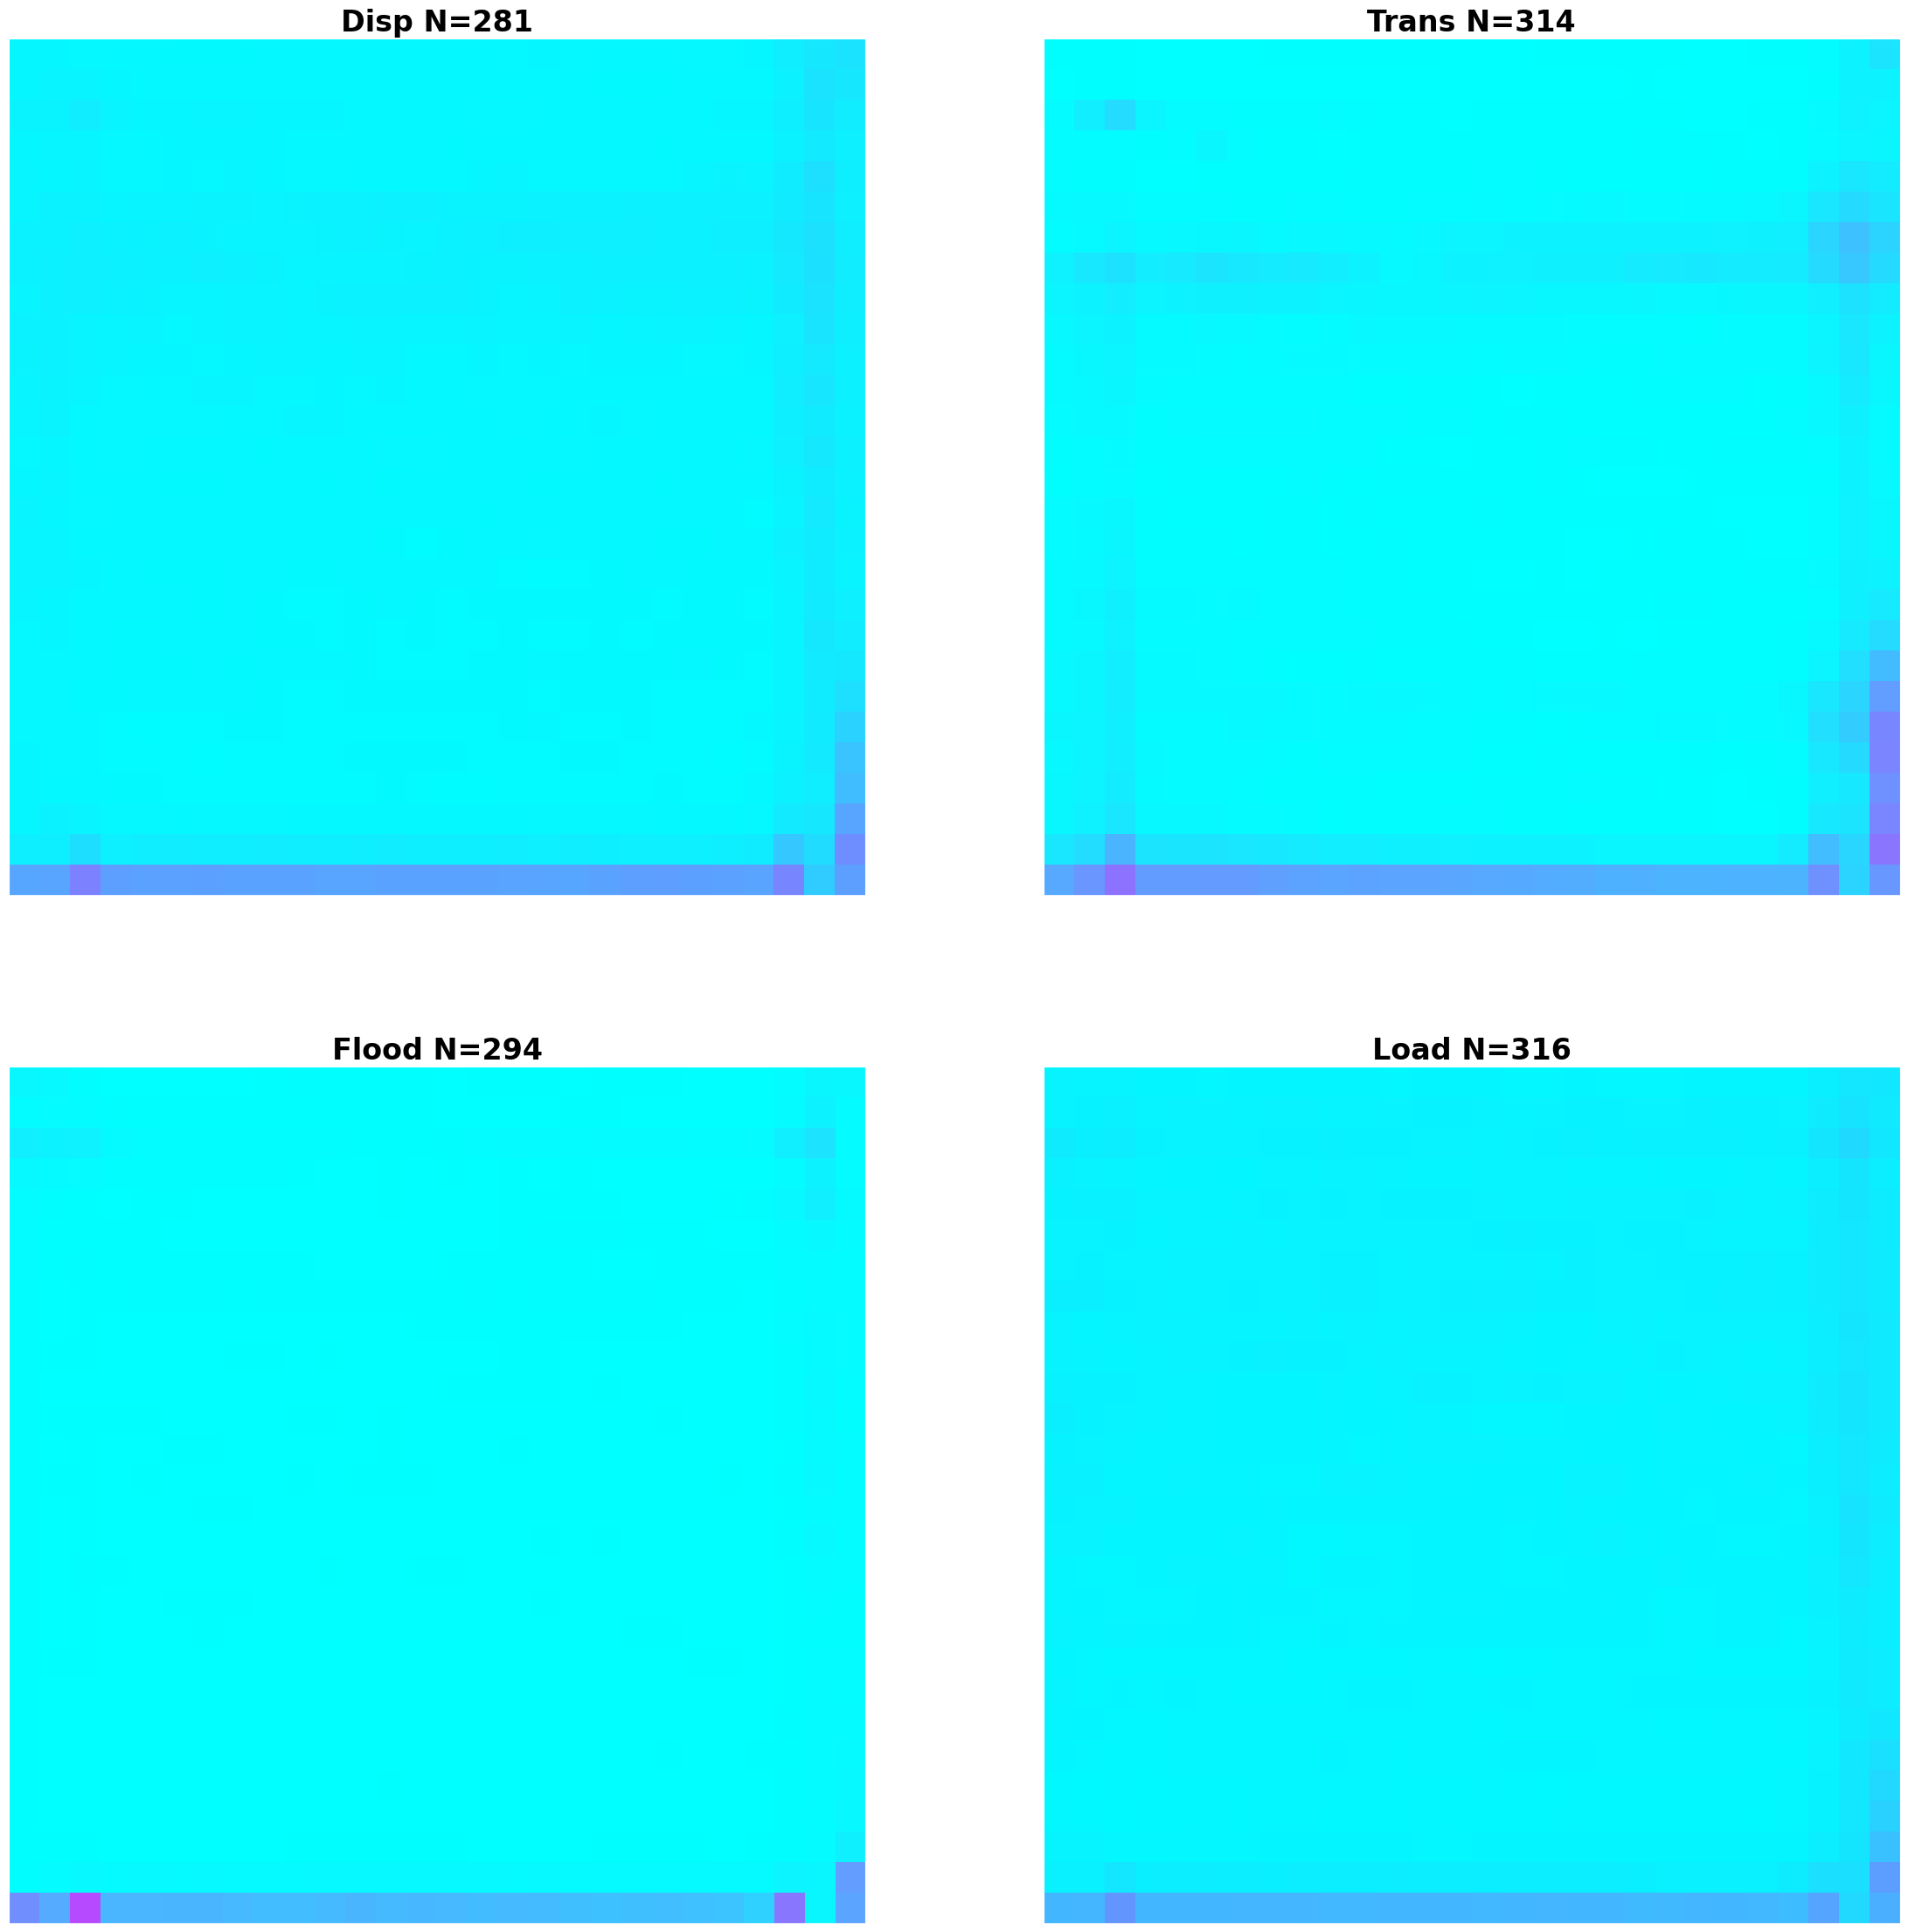

In [47]:
mean_disp =     sum_disp/count_disp
mean_trans =    sum_trans/count_trans
mean_flood =    sum_flood/count_flood
mean_load =     sum_load/count_load

cool = cm.get_cmap("cool")
cool_colors = cool(np.arange(256))[:, :3]
colorThreshold=0
cool_colors[0:colorThreshold] = 0
fig,axs= plt.subplots(2,2,figsize=(28,28))#neuer plot
heatmap_disp_Array2Dint = cool_colors[(mean_disp * 255).astype(int)]
heatmap_disp_Img = tf.keras.preprocessing.image.array_to_img(heatmap_disp_Array2Dint)
axs[0,0].set_title("Disp N="+str(count_disp), fontdict={'color':  'black','weight': 'bold','size': 24})
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(heatmap_disp_Img.rotate(180))

heatmap_trans_Array2Dint = cool_colors[(mean_trans * 255).astype(int)]
heatmap_trans_Img = tf.keras.preprocessing.image.array_to_img(heatmap_trans_Array2Dint)
axs[0,1].set_title("Trans N="+str(count_trans), fontdict={'color':  'black','weight': 'bold','size': 24})
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].imshow(heatmap_trans_Img.rotate(180))

heatmap_flood_Array2Dint = cool_colors[(mean_flood * 255).astype(int)]
heatmap_flood_Img = tf.keras.preprocessing.image.array_to_img(heatmap_flood_Array2Dint)
axs[1,0].set_title("Flood N="+str(count_flood), fontdict={'color':  'black','weight': 'bold','size': 24})
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,0].imshow(heatmap_flood_Img.rotate(180))

heatmap_load_Array2Dint = cool_colors[(mean_load * 255).astype(int)]
heatmap_load_Img = tf.keras.preprocessing.image.array_to_img(heatmap_load_Array2Dint)
axs[1,1].set_title("Load N="+str(count_load), fontdict={'color':  'black','weight': 'bold','size': 24})
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].imshow(heatmap_load_Img.rotate(180))
plt.show()

In [28]:
print("Model: " +path_model)
print("Data: " +path_tf_dataset_test)

Model: /mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/cnn_acc85.0_auc0.9.h5
Data: /mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/tf_dataset_test.tf


In [51]:
plt.savefig(f"{path_model.split('cnn')[0]}mean.png")

<Figure size 640x480 with 0 Axes>